In [1]:
import torch
import torch.nn as nn
from datasets import load_from_disk
from torch.utils.data import DataLoader
from diffusers import AutoencoderKL
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from models import DiTBlock, TimestepEmbedder
from tqdm.notebook import tqdm


In [2]:
bs = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def nearest_divisor(scaled_num_heads, embed_dim):
    # Find all divisors of embed_dim
    divisors = [i for i in range(1, embed_dim + 1) if embed_dim % i == 0]
    
    # Find the nearest divisor
    nearest = min(divisors, key=lambda x: abs(x - scaled_num_heads))
    
    return nearest

class TransformerBackbone(nn.Module):
    def __init__(self, input_dim: int, embed_dim: int, num_layers: int, num_heads: int, mlp_dim: int, 
                 num_experts: int = 4, active_experts: int = 2, dropout: float = 0.1):
        super().__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        self.class_embedding = nn.Linear(embed_dim, embed_dim)

        # Define scaling ranges for m_f and m_a
        mf_min, mf_max = 0.5, 4.0
        ma_min, ma_max = 0.5, 1.0

        self.layers = nn.ModuleList()
        for i in range(num_layers):
            # Calculate scaling factors for the i-th layer using linear interpolation
            mf = mf_min + (mf_max - mf_min) * i / (num_layers - 1)
            ma = ma_min + (ma_max - ma_min) * i / (num_layers - 1)

            # Scale the dimensions according to the scaling factors
            scaled_mlp_dim = int(mlp_dim * mf)
            scaled_num_heads = max(1, int(num_heads * ma))
            scaled_num_heads = nearest_divisor(scaled_num_heads, embed_dim)
            mlp_ratio = int(scaled_mlp_dim / embed_dim)

            # Choose layer type based on the layer index (even/odd)
            if i % 2 == 0:  # Even layers use regular DiT
                self.layers.append(DiTBlock(embed_dim, scaled_num_heads, mlp_ratio, 
                                            1, 1, use_flash_attn=False, attn_drop=dropout))
            else:  # Odd layers use MoE DiT
                self.layers.append(DiTBlock(embed_dim, scaled_num_heads, mlp_ratio, 
                                               num_experts, active_experts, use_flash_attn=True, attn_drop=dropout))


        self.output_layer = nn.Linear(embed_dim, input_dim)

    def forward(self, x, c_emb):
        x = self.input_embedding(x)
        class_emb = self.class_embedding(c_emb)

        for layer in self.layers:
            x = layer(x, class_emb)

        x = self.output_layer(x)
        return x

In [4]:
class PatchEmbed(nn.Module):
    def __init__(self, in_channels, embed_dim, patch_size):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.patch_size = patch_size

    def forward(self, x):
        x = self.proj(x)  # (B, C, H, W) -> (B, E, H', W')
        return x.flatten(2).transpose(1, 2)  # (B, E, H', W') -> (B, H'*W', E)

In [5]:
def get_2d_sincos_pos_embed(embed_dim, h, w):
    """
    :param embed_dim: dimension of the embedding
    :param h: height of the grid
    :param w: width of the grid
    :return: [h*w, embed_dim] or [1+h*w, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = torch.arange(h, dtype=torch.float32)
    grid_w = torch.arange(w, dtype=torch.float32)
    grid = torch.meshgrid(grid_h, grid_w, indexing='ij')
    grid = torch.stack(grid, dim=0)

    grid = grid.reshape([2, 1, h, w])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = torch.cat([emb_h, emb_w], dim=1) # (H*W, D)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = torch.arange(embed_dim // 2, dtype=torch.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = torch.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = torch.sin(out) # (M, D/2)
    emb_cos = torch.cos(out) # (M, D/2)

    emb = torch.cat([emb_sin, emb_cos], dim=1)  # (M, D)
    return emb

def get_timestep_embedding(timesteps, embedding_dim):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param embedding_dim: the dimension of the output.
    :return: an [N x embedding_dim] Tensor of positional embeddings.
    """
    assert len(timesteps.shape) == 1, "Timesteps should be a 1-D tensor"

    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000, dtype=torch.float32)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb

In [6]:
class PatchMixer(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers=2):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MicroDiffusion(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_layers, num_heads, mlp_dim, class_label_dim, 
                 num_experts=4, active_experts=2, dropout=0.1):
        super().__init__()
        
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
        # Image processing
        self.patch_embed = PatchEmbed(in_channels, embed_dim, patch_size)
        
        # Timestep embedding
        self.time_embed = TimestepEmbedder(embed_dim)
        
        # Class embedding
        self.class_embed = nn.Linear(class_label_dim, embed_dim)

        # MHA for timestep and class
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
        # MLP for timestep and class
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Pool + MLP for (MHA + MLP)
        self.pool_mlp = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Linear layer after MHA+MLP
        self.linear = nn.Linear(embed_dim, embed_dim)
        
        # Patch-mixer
        self.patch_mixer = PatchMixer(embed_dim, num_heads)
        
        # Backbone transformer model
        self.backbone = TransformerBackbone(embed_dim, embed_dim, num_layers, num_heads, mlp_dim, 
                                        num_experts, active_experts, dropout)
        
        # Output layer
        self.output = nn.Linear(embed_dim, patch_size * patch_size * in_channels)

    def forward(self, x, t, class_labels, mask):
        # x: (batch_size, in_channels, height, width)
        # t: (batch_size, 1)
        # class_labels: (batch_size, class_embed_dim)
        # mask: (batch_size, num_patches)
        
        batch_size, channels, height, width = x.shape

        # Image processing
        x = self.patch_embed(x)  # (batch_size, num_patches, embed_dim)
        
        # Generate positional embeddings
        pos_embed = get_2d_sincos_pos_embed(self.embed_dim, height // self.patch_size, width // self.patch_size)
        pos_embed = pos_embed.to(x.device).unsqueeze(0)
        
        x = x + pos_embed
        
        # Timestep embedding
        t_emb = self.time_embed(t)  # (batch_size, embed_dim)

        # Class embedding
        c_emb = self.class_embed(class_labels)  # (batch_size, embed_dim)

        mha_out = self.mha(t_emb.unsqueeze(1), c_emb.unsqueeze(1), c_emb.unsqueeze(1))[0].squeeze(1)
        mlp_out = self.mlp(mha_out)
        
        # Pool + MLP
        pool_out = self.pool_mlp(mlp_out.unsqueeze(2))

        # Pool + MLP + t_emb
        pool_out = (pool_out + t_emb).unsqueeze(1)
        
        # Apply linear layer
        cond_signal = self.linear(mlp_out).unsqueeze(1)  # (batch_size, 1, embed_dim)
        
        # Add conditioning signal to all patches
        x = x + cond_signal + pool_out
        
        # Patch-mixer
        x = self.patch_mixer(x)
        
        # Apply mask
        x = x * mask.unsqueeze(-1)

        # MHA + MLP + Pool + MLP + t_emb
        x = x + mlp_out.unsqueeze(1) + pool_out
        
        # Backbone transformer model
        x = self.backbone(x, c_emb)
        
        # Output only unmasked patches
        x = x * mask.unsqueeze(-1)
        
        # Final output layer
        x = self.output(x)
        
        # Reshape output to image format
        x = x.view(batch_size, channels, height, width)
        
        return x

In [7]:
# Run the precompute_latents.ipynb notebook to download the dataset and save it to the datasets/CelebA-attrs-latents folder

train_ds = load_from_disk("datasets/CelebA-attrs-latents/train")
# validation_ds = load_from_disk("datasets/CelebA-attrs-latents/validation")
# test_ds = load_from_disk("datasets/CelebA-attrs-latents/test")

Loading dataset from disk:   0%|          | 0/153 [00:00<?, ?it/s]

In [8]:
# train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, pin_memory=True, pin_memory_device=device)
# validation_dl = DataLoader(validation_ds, batch_size=bs, shuffle=True, pin_memory=True, pin_memory_device=device)
# test_dl = DataLoader(test_ds, batch_size=bs, shuffle=True, pin_memory=True, pin_memory_device=device)  

In [9]:
train_ds[0]

{'image': tensor([[[ 0.9843,  0.9843,  0.9843,  ...,  0.9294,  1.0000,  0.9922],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9451,  1.0000,  0.9922],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9608,  1.0000,  1.0000],
          ...,
          [ 0.1059, -0.0902,  0.1451,  ..., -0.0431, -0.0431, -0.0510],
          [ 0.0196,  0.0824,  0.3098,  ..., -0.0745, -0.0588, -0.0745],
          [ 0.3176,  0.6000,  0.9137,  ..., -0.0745, -0.0588, -0.0588]],
 
         [[ 0.8118,  0.8118,  0.8118,  ...,  0.7882,  0.8588,  0.8667],
          [ 0.8118,  0.8118,  0.8118,  ...,  0.8039,  0.8588,  0.8667],
          [ 0.8118,  0.8118,  0.8118,  ...,  0.8196,  0.8667,  0.8745],
          ...,
          [-0.4118, -0.6078, -0.3882,  ..., -0.5686, -0.5686, -0.5686],
          [-0.5137, -0.4431, -0.2235,  ..., -0.6157, -0.6078, -0.6000],
          [-0.2157,  0.0667,  0.3804,  ..., -0.6157, -0.6078, -0.6078]],
 
         [[ 0.5216,  0.5216,  0.5216,  ...,  0.6941,  0.7490,  0.7412],
          [ 0.5216,

In [10]:
train_ds[0]["prompt_string"]


'[-1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1]'

In [11]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", cache_dir="models/vae")
vae = vae.to(device)

In [12]:
latents = train_ds[0]["latents"].to(device).unsqueeze(0)
reconstruction = vae.decode(latents).sample

d:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\diffusers\models\attention_processor.py:1584: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


In [13]:
latents.shape

torch.Size([1, 4, 27, 22])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03305292..1.0232362].


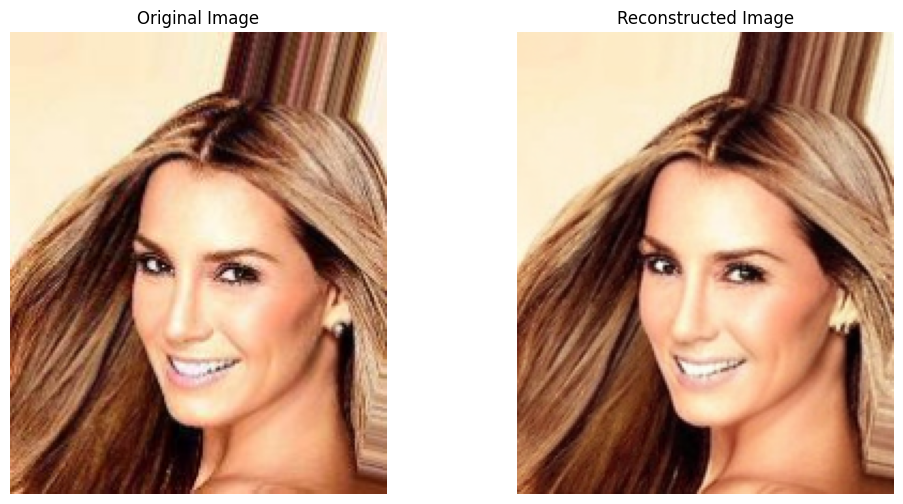

In [14]:
with torch.no_grad():
    # Move the tensors back to the CPU if they are on a GPU and remove the batch dimension
    img_cpu = train_ds[0]["image"].squeeze(0).cpu()
    reconstruction_cpu = reconstruction.squeeze(0).cpu()

    # Convert the tensors to numpy arrays for plotting
    img_np = img_cpu.permute(1, 2, 0).numpy()
    reconstruction_np = reconstruction_cpu.permute(1, 2, 0).numpy()

    # Rescale the reconstructed image from [-1, 1] to [0, 1]
    img_np = (img_np + 1) / 2
    reconstruction_np = (reconstruction_np + 1) / 2

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    axes[0].imshow(img_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')  # Hide the axes

    # Display the reconstructed image
    axes[1].imshow(reconstruction_np)
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')  # Hide the axes

    # Show the plot
    plt.show()

In [15]:
def strings_to_tensor(string_list):
    """
    Converts a list of strings, each representing a list (e.g., "[1, 2, 3]"), 
    into a PyTorch tensor.

    Args:
        string_list (list of str): A list of strings, where each string is a list in string form.

    Returns:
        torch.Tensor: A PyTorch tensor containing the data from the lists.
    """
    # Convert each string to a list using eval
    list_of_lists = [eval(s) for s in string_list]
    
    # Convert the list of lists to a PyTorch tensor
    tensor = torch.tensor(list_of_lists, dtype=torch.float32)
    
    return tensor

In [16]:
def random_mask(bs: int, height: int, width: int, patch_size: int, mask_ratio: float, device: str = "cuda") -> torch.Tensor:
    """
    Generates a random mask for patched images. Randomly selects patches to mask.

    Args:
        bs (int): Batch size.
        height (int): Height of the image.
        width (int): Width of the image.
        patch_size (int): Size of the patches.
        mask_ratio (float): Ratio of patches to mask. Ranges from 0 to 1.

    Returns:
        mask (torch.Tensor): A tensor of shape (bs, num_patches) with values in {0, 1}.
    """
    num_patches = (height // patch_size) * (width // patch_size)
    num_patches_to_mask = int(num_patches * mask_ratio)
    
    # Create a tensor of random values
    rand_tensor = torch.rand(bs, num_patches, device=device)
    
    # Sort the random tensor and get the indices
    _, indices = torch.sort(rand_tensor, dim=1)
    
    # Create a mask tensor initialized with ones
    mask = torch.ones(bs, num_patches, device=device)
    
    # Set the first num_patches_to_mask indices to 0 for each batch
    mask[torch.arange(bs).unsqueeze(1), indices[:, :num_patches_to_mask]] = 0
    
    # Ensure the final shape is (bs, num_patches)
    mask = mask.view(bs, num_patches)

    return mask

In [17]:
input_dim = 4  # 4 channels in latent space
patch_size = 1 
embed_dim = 384
num_layers = 12
num_heads = 6
mlp_dim = embed_dim * 4
class_label_dim = 40  # 40 attributes in CelebA dataset

epochs = 1000

In [18]:
model = MicroDiffusion(input_dim, patch_size, embed_dim, num_layers, num_heads, mlp_dim, class_label_dim)
model = model.to(device)

In [19]:
# Print model parameters count
print(sum(p.numel() for p in model.parameters()))

153302404


In [20]:
# Attempt overfitting to just one batch of images first
from torch.utils.data import Subset
subset = Subset(train_ds, range(9))
train_dl = DataLoader(subset, batch_size=4, shuffle=False, pin_memory=True, pin_memory_device=device)

In [21]:
from torch.optim.lr_scheduler import OneCycleLR

# Define your loss function and optimizer as before
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Calculate the total number of steps in your single epoch
# total_steps = len(train_dl) * epochs

# Add the OneCycleLR scheduler
# scheduler = OneCycleLR(optimizer, max_lr=1e-4, total_steps=total_steps)

In [22]:
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_

scaler = GradScaler()

loss_history = []

for epoch in range(epochs):
    epoch_loss = 0.0

    pbar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}")
    for batch_idx, batch in enumerate(pbar):
        bs = batch["latents"].shape[0]
        image_prompts = strings_to_tensor(batch["prompt_string"]).to(device)
        latents = batch["latents"].to(device)

        noise = torch.randn_like(latents, device=device)
        noise_amt = torch.rand(bs, device=device)

        noised_latents = latents * (1 - noise_amt.view(bs, 1, 1, 1)) + noise * noise_amt.view(bs, 1, 1, 1)

        mask = random_mask(bs, latents.shape[-2], latents.shape[-1], patch_size, 0.5)
        masked_latents = latents * mask.unsqueeze(1).view(bs, 1, latents.shape[-2], latents.shape[-1])
        
        optimizer.zero_grad()

        with autocast():
            pred = model(noised_latents, noise_amt * 1000, image_prompts, mask)
            loss = loss_fn(pred, masked_latents)

        scaler.scale(loss).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()
        # scheduler.step()

        loss_value = loss.item()
        epoch_loss += loss_value
        loss_history.append(loss_value)

        pbar.set_postfix({'loss': f'{loss_value:.4f}'})

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(train_dl)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")
    
    # Step the scheduler with the average loss
    # scheduler.step(avg_loss)

Epoch 780 average loss: 16.4273


Epoch 781/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 781 average loss: 16.2260


Epoch 782/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 782 average loss: 15.8720


Epoch 783/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 783 average loss: 16.1102


Epoch 784/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 784 average loss: 16.2759


Epoch 785/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 785 average loss: 16.0916


Epoch 786/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 786 average loss: 16.6349


Epoch 787/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 787 average loss: 16.6112


Epoch 788/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 788 average loss: 16.3448


Epoch 789/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 789 average loss: 16.0505


Epoch 790/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 790 average loss: 16.1516


Epoch 791/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 791 average loss: 16.3973


Epoch 792/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 792 average loss: 16.0005


Epoch 793/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 793 average loss: 16.4926


Epoch 794/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 794 average loss: 16.5512


Epoch 795/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 795 average loss: 16.2599


Epoch 796/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 796 average loss: 16.4821


Epoch 797/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 797 average loss: 16.2508


Epoch 798/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 798 average loss: 16.1787


Epoch 799/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 799 average loss: 16.3668


Epoch 800/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 800 average loss: 16.0078


Epoch 801/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 801 average loss: 16.1120


Epoch 802/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 802 average loss: 16.0626


Epoch 803/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 803 average loss: 16.1582


Epoch 804/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 804 average loss: 16.2039


Epoch 805/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 805 average loss: 16.3301


Epoch 806/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 806 average loss: 16.4587


Epoch 807/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 807 average loss: 16.2070


Epoch 808/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 808 average loss: 16.4790


Epoch 809/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 809 average loss: 16.2241


Epoch 810/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 810 average loss: 16.0866


Epoch 811/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 811 average loss: 16.3247


Epoch 812/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 812 average loss: 16.3913


Epoch 813/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 813 average loss: 16.2635


Epoch 814/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 814 average loss: 16.1135


Epoch 815/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 815 average loss: 16.4657


Epoch 816/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 816 average loss: 16.5674


Epoch 817/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 817 average loss: 16.1805


Epoch 818/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 818 average loss: 16.0861


Epoch 819/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 819 average loss: 16.1150


Epoch 820/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 820 average loss: 16.1206


Epoch 821/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 821 average loss: 16.0280


Epoch 822/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 822 average loss: 16.0825


Epoch 823/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 823 average loss: 16.4995


Epoch 824/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 824 average loss: 16.7114


Epoch 825/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 825 average loss: 16.1999


Epoch 826/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 826 average loss: 16.6621


Epoch 827/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 827 average loss: 16.4384


Epoch 828/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 828 average loss: 16.2235


Epoch 829/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 829 average loss: 16.1385


Epoch 830/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 830 average loss: 16.4554


Epoch 831/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 831 average loss: 16.0936


Epoch 832/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 832 average loss: 16.5490


Epoch 833/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 833 average loss: 16.4766


Epoch 834/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 834 average loss: 16.2677


Epoch 835/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 835 average loss: 16.3384


Epoch 836/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 836 average loss: 16.3546


Epoch 837/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 837 average loss: 15.9639


Epoch 838/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 838 average loss: 16.3983


Epoch 839/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 839 average loss: 16.1646


Epoch 840/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 840 average loss: 16.5022


Epoch 841/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 841 average loss: 16.2358


Epoch 842/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 842 average loss: 16.3348


Epoch 843/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 843 average loss: 16.4250


Epoch 844/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 844 average loss: 16.0953


Epoch 845/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 845 average loss: 16.3083


Epoch 846/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 846 average loss: 16.4550


Epoch 847/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 847 average loss: 16.4763


Epoch 848/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 848 average loss: 16.6539


Epoch 849/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 849 average loss: 16.0813


Epoch 850/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 850 average loss: 16.4398


Epoch 851/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 851 average loss: 16.2988


Epoch 852/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 852 average loss: 16.2605


Epoch 853/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 853 average loss: 16.2109


Epoch 854/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 854 average loss: 16.4431


Epoch 855/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 855 average loss: 16.2068


Epoch 856/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 856 average loss: 16.0020


Epoch 857/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 857 average loss: 16.0901


Epoch 858/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 858 average loss: 16.2482


Epoch 859/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 859 average loss: 16.5149


Epoch 860/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 860 average loss: 16.0154


Epoch 861/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 861 average loss: 16.3330


Epoch 862/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 862 average loss: 16.2142


Epoch 863/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 863 average loss: 16.3020


Epoch 864/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 864 average loss: 16.1858


Epoch 865/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 865 average loss: 16.4497


Epoch 866/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 866 average loss: 16.4045


Epoch 867/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 867 average loss: 16.2605


Epoch 868/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 868 average loss: 16.2223


Epoch 869/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 869 average loss: 16.1637


Epoch 870/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 870 average loss: 16.5394


Epoch 871/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 871 average loss: 17.1319


Epoch 872/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 872 average loss: 16.2473


Epoch 873/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 873 average loss: 16.5060


Epoch 874/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 874 average loss: 16.3130


Epoch 875/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 875 average loss: 16.3171


Epoch 876/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 876 average loss: 16.3029


Epoch 877/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 877 average loss: 16.4172


Epoch 878/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 878 average loss: 15.9519


Epoch 879/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 879 average loss: 16.3488


Epoch 880/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 880 average loss: 16.2129


Epoch 881/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 881 average loss: 16.1170


Epoch 882/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 882 average loss: 15.9501


Epoch 883/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 883 average loss: 16.3500


Epoch 884/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 884 average loss: 16.4862


Epoch 885/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 885 average loss: 16.3966


Epoch 886/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 886 average loss: 16.3366


Epoch 887/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 887 average loss: 16.1869


Epoch 888/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 888 average loss: 16.4013


Epoch 889/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 889 average loss: 16.1266


Epoch 890/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 890 average loss: 16.0591


Epoch 891/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 891 average loss: 16.2054


Epoch 892/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 892 average loss: 16.5784


Epoch 893/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 893 average loss: 16.1882


Epoch 894/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 894 average loss: 16.1221


Epoch 895/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 895 average loss: 16.5897


Epoch 896/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 896 average loss: 16.2302


Epoch 897/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 897 average loss: 16.3244


Epoch 898/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 898 average loss: 16.1426


Epoch 899/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 899 average loss: 16.3844


Epoch 900/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 900 average loss: 16.3583


Epoch 901/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 901 average loss: 16.1470


Epoch 902/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 902 average loss: 16.2187


Epoch 903/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 903 average loss: 16.2430


Epoch 904/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 904 average loss: 16.2487


Epoch 905/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 905 average loss: 16.2561


Epoch 906/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 906 average loss: 16.3143


Epoch 907/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 907 average loss: 16.2146


Epoch 908/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 908 average loss: 15.9616


Epoch 909/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 909 average loss: 16.1871


Epoch 910/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 910 average loss: 16.2158


Epoch 911/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 911 average loss: 16.3213


Epoch 912/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 912 average loss: 16.3252


Epoch 913/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 913 average loss: 16.0296


Epoch 914/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 914 average loss: 16.4394


Epoch 915/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 915 average loss: 16.1770


Epoch 916/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 916 average loss: 15.8709


Epoch 917/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 917 average loss: 16.4564


Epoch 918/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 918 average loss: 16.2067


Epoch 919/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 919 average loss: 16.1808


Epoch 920/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 920 average loss: 16.3745


Epoch 921/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 921 average loss: 16.2616


Epoch 922/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 922 average loss: 16.2026


Epoch 923/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 923 average loss: 16.6657


Epoch 924/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 924 average loss: 16.0571


Epoch 925/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 925 average loss: 16.0460


Epoch 926/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 926 average loss: 16.3790


Epoch 927/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 927 average loss: 15.9356


Epoch 928/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 928 average loss: 15.7527


Epoch 929/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 929 average loss: 16.4830


Epoch 930/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 930 average loss: 16.4498


Epoch 931/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 931 average loss: 16.3294


Epoch 932/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 932 average loss: 16.1737


Epoch 933/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 933 average loss: 16.2577


Epoch 934/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 934 average loss: 16.1087


Epoch 935/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 935 average loss: 16.0068


Epoch 936/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 936 average loss: 15.9036


Epoch 937/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 937 average loss: 16.6958


Epoch 938/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 938 average loss: 16.4485


Epoch 939/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 939 average loss: 16.0490


Epoch 940/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 940 average loss: 16.2489


Epoch 941/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 941 average loss: 16.3027


Epoch 942/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 942 average loss: 15.9741


Epoch 943/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 943 average loss: 16.3718


Epoch 944/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 944 average loss: 16.3814


Epoch 945/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 945 average loss: 16.3843


Epoch 946/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 946 average loss: 16.3707


Epoch 947/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 947 average loss: 16.2479


Epoch 948/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 948 average loss: 16.3357


Epoch 949/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 949 average loss: 16.7008


Epoch 950/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 950 average loss: 16.5684


Epoch 951/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 951 average loss: 16.1777


Epoch 952/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 952 average loss: 16.3012


Epoch 953/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 953 average loss: 16.2755


Epoch 954/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 954 average loss: 16.6009


Epoch 955/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 955 average loss: 16.2746


Epoch 956/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 956 average loss: 16.3407


Epoch 957/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 957 average loss: 16.4949


Epoch 958/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 958 average loss: 16.2562


Epoch 959/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 959 average loss: 16.3266


Epoch 960/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 960 average loss: 16.3980


Epoch 961/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 961 average loss: 16.2181


Epoch 962/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 962 average loss: 16.1345


Epoch 963/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 963 average loss: 15.9613


Epoch 964/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 964 average loss: 16.0155


Epoch 965/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 965 average loss: 16.1980


Epoch 966/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 966 average loss: 16.2615


Epoch 967/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 967 average loss: 16.4410


Epoch 968/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 968 average loss: 16.1783


Epoch 969/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 969 average loss: 16.4786


Epoch 970/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 970 average loss: 16.0671


Epoch 971/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 971 average loss: 16.0763


Epoch 972/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 972 average loss: 16.0616


Epoch 973/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 973 average loss: 15.9087


Epoch 974/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 974 average loss: 15.9100


Epoch 975/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 975 average loss: 16.0165


Epoch 976/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 976 average loss: 16.3472


Epoch 977/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 977 average loss: 16.3210


Epoch 978/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 978 average loss: 16.4223


Epoch 979/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 979 average loss: 16.2891


Epoch 980/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 980 average loss: 16.0661


Epoch 981/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 981 average loss: 16.2441


Epoch 982/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 982 average loss: 16.0478


Epoch 983/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 983 average loss: 16.1690


Epoch 984/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 984 average loss: 16.0372


Epoch 985/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 985 average loss: 16.2003


Epoch 986/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 986 average loss: 15.9630


Epoch 987/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 987 average loss: 16.0754


Epoch 988/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 988 average loss: 16.3984


Epoch 989/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 989 average loss: 16.2402


Epoch 990/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 990 average loss: 16.5369


Epoch 991/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 991 average loss: 16.3829


Epoch 992/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 992 average loss: 16.0017


Epoch 993/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 993 average loss: 16.3844


Epoch 994/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 994 average loss: 16.1767


Epoch 995/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 995 average loss: 16.3064


Epoch 996/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 996 average loss: 16.0308


Epoch 997/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 997 average loss: 16.1284


Epoch 998/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 998 average loss: 16.1784


Epoch 999/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 999 average loss: 15.9049


Epoch 1000/1000:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1000 average loss: 15.9746


In [23]:
import os

# Create models directory if it doesn't exist
os.makedirs('models/diffusion', exist_ok=True)

# Save the model
torch.save(model.state_dict(), 'models/diffusion/microdiffusion_model.pth')

print("Model saved successfully.")


Model saved successfully.


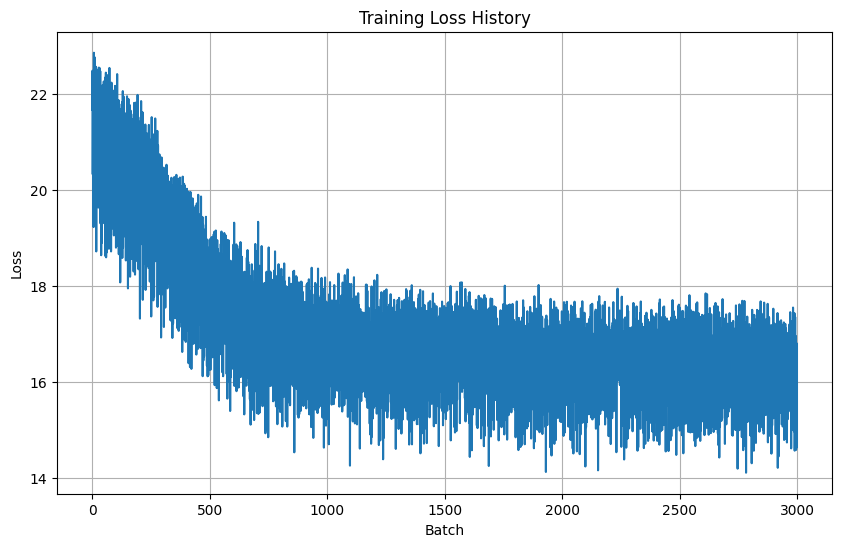

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('Training Loss History')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [28]:
def sample(model, class_labels, mask, bs: int = 9, steps: int = 100):
    x = torch.randn(bs, 4, 27, 22).to(device)

    pred_weight = 4/steps
    x_weight = 1 - pred_weight

    for step in range(steps):
        timestep = (step * 1000 / steps) * torch.ones(bs, device=device)
        pred = model.forward(x, timestep, class_labels, mask)
        x = x * x_weight + pred * pred_weight
    return x

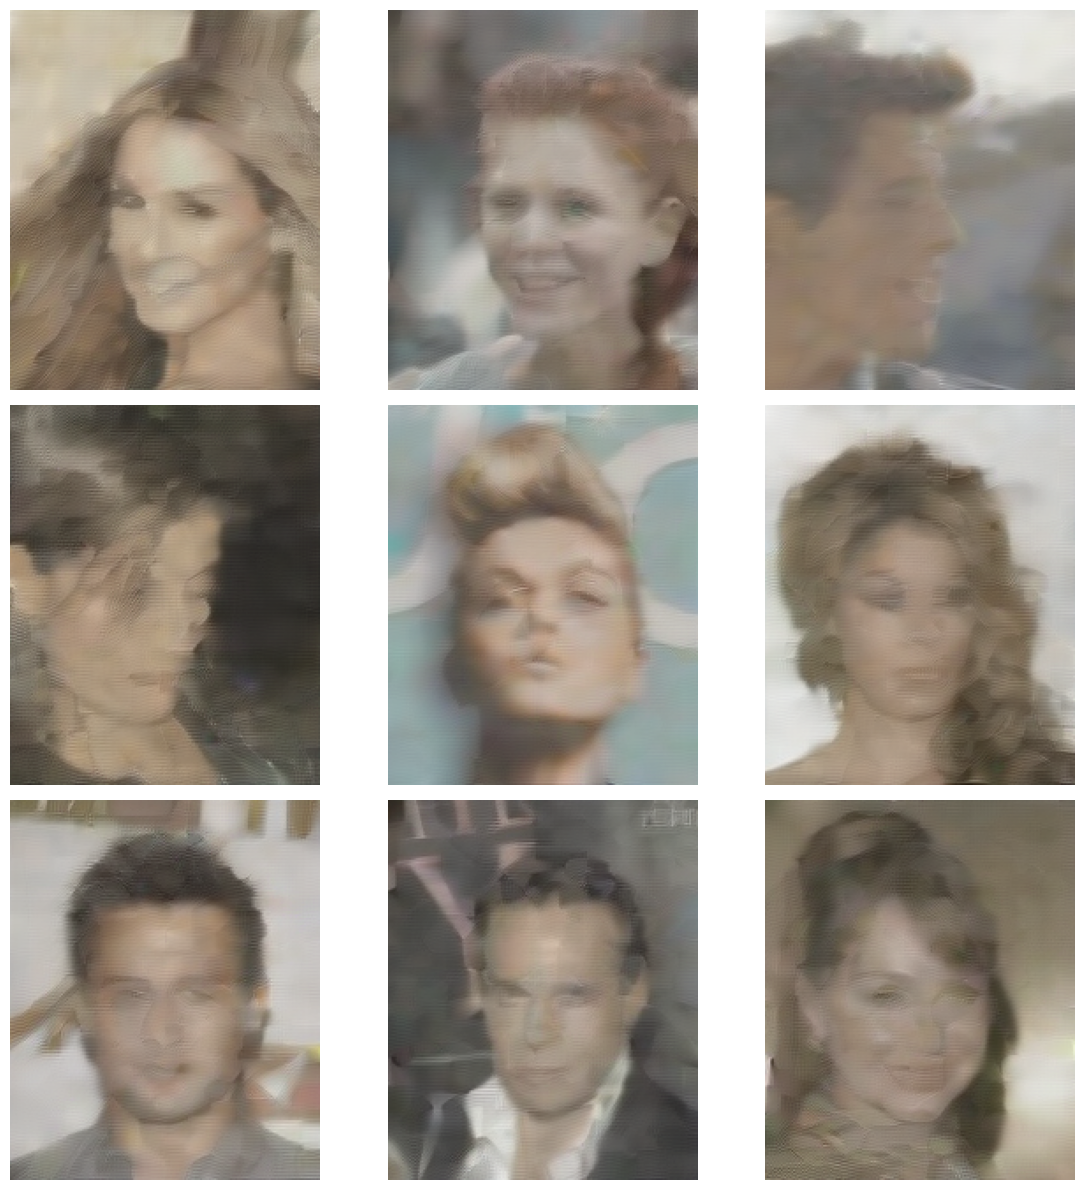

In [29]:
import numpy as np

mask = random_mask(9, latents.shape[-2], latents.shape[-1], patch_size, 0.)
noise = torch.randn(9, 4, 27, 22).to(device)
noise_level = torch.ones(9).to(device)

image_prompts = train_ds[0:9]["prompt_string"]
image_prompts = strings_to_tensor(image_prompts).to(device)

with torch.no_grad():
    with autocast():
        # pred = model.forward(noise, noise_level*1000, image_prompts, mask)
        pred = sample(model, image_prompts, mask)
        pred = vae.decode(pred).sample

ground_truth = train_ds[0:9]["image"]

with torch.no_grad():
    pred_cpu = pred.cpu()
    pred_np = pred_cpu.permute(0, 2, 3, 1).numpy()
    pred_np = (pred_np + 1) / 2
    pred_np = (pred_np * 255).astype(np.uint8)  # Convert to uint8

    ground_truth_cpu = ground_truth.cpu()
    ground_truth_np = ground_truth_cpu.permute(0, 2, 3, 1).numpy()
    ground_truth_np = (ground_truth_np + 1) / 2
    ground_truth_np = (ground_truth_np * 255).astype(np.uint8)  # Convert to uint8

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for i, ax in enumerate(axes.flatten()):
        if i < pred_np.shape[0]:
            ax.imshow(pred_np[i])
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
